In [44]:
import treescope
import torch
from pathlib import Path
from src.model import EvolutionOperator
from src.data import DESRESDataset
from src.configs import ModelArgs # noqa
from torch.utils.data import RandomSampler
from torch_geometric.loader import DataLoader
from loguru import logger
from dataclasses import asdict
import linear_operator_learning as lol
import matplotlib.pyplot as plt
import numpy as np
import pickle


#treescope.basic_interactive_setup()

In [45]:
# Write new configs on wandb.
import wandb

protein_id = "CLN025"
traj_id = 0
epoch = 9
api = wandb.Api()

for run in api.runs(f"csml/encoderops-{protein_id}-{traj_id}"):
    updated: bool = False
    if run.state == "finished":
        data_path = Path(f"logs/encoderops-{protein_id}-{traj_id}/{run.id}")
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
        model_args = asdict(model.model_args)
        for k, v in model_args.items():
            if k not in run.config:
                run.config[k] = v
                updated = True
        run.update()
        if updated:
            logger.info(f"Updated run {run.id}")
        else:
            logger.info(f"Run {run.id} was already up to date")

StopIteration: 

In [43]:
def load_run(run_id: str, protein_id: str, traj_id:int = 0, epoch: int | None = None, center_covariance: bool = False, progress: bool = True, subsample: float | None = None):
    reg=1e-4
    data_path = Path(f"logs/encoderops-{protein_id}-{traj_id}/{run_id}")
    if epoch is None:
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob("**/last.ckpt")))
    else:
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
    dataset = DESRESDataset(model.data_args.protein_id, lagtime=model.data_args.lagtime)
    embeddings = {"t": [], "lag": []}
    model = model.eval()
    if subsample is not None:
        num_samples = int(len(dataset)*subsample)
        sampler = RandomSampler(dataset, num_samples=num_samples)
        dataloader = DataLoader(dataset, batch_size=128, sampler=sampler)
    else:
        dataloader = DataLoader(
            dataset, batch_size=128, shuffle=False
        )

    with torch.no_grad():
        if progress:
            from tqdm.auto import tqdm
            dataloader = tqdm(dataloader)
        for batch in dataloader:
            for k, v in batch.items():
                batch[k] = v.to(model.device)
            # data
            x_t = model._setup_graph_data(batch)
            x_lag = model._setup_graph_data(batch, key="item_lag")
            # forward
            f_t = model.forward_nn(x_t)
            f_lag = model.forward_nn(x_lag)
            embeddings["t"].append((f_t.detach().cpu()))
            embeddings["lag"].append((f_lag.detach().cpu()))
    phi_t = torch.cat(embeddings["t"])
    phi_lag = torch.cat(embeddings["lag"])
    cov_X = model.cov.to('cpu')
    cov_X += torch.eye(cov_X.shape[0], device=cov_X.device) * reg
    cov_XY = model.cross_cov.to('cpu')
    G = torch.linalg.solve(cov_X, cov_XY)
    l, Q = torch.linalg.eig(G) # Q @ torch.diag(l) @ Q^-1 = G
    r_fun = phi_t.to(dtype=Q.dtype) @ Q 
    results = {
        "embedding_t": phi_t,
        "embedding_lag": phi_lag,
        "eigenvalues": l,
        "eigenvectors": Q,
        "r_fun": r_fun
    }
    return model, results

In [8]:
protein_id = "CLN025"
run_id = "mgp4cfv7"
epoch = 4
model, results = load_run(run_id, protein_id, epoch=epoch, subsample=0.04, center_covariance=True)

/home/novelli/encoderops/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 168/168 [01:39<00:00,  1.69it/s]


In [22]:
results = compute_tica(model, results)

In [ ]:
# reg = 1e-4
# if Path(f"analysis/results-{protein_id}-{traj_id}.pkl").exists():
#     results = pickle.load(open(f"analysis/results-{protein_id}-{traj_id}.pkl", "rb"))
# else:
#     results = {}
#     for run in api.runs(f"csml/encoderops-{protein_id}-{traj_id}"):
#         if run.state == "finished":
#             logger.info(f"Run {run.id}")
#             model, run_results = load_run(run.id, protein_id, progress=False)
#             results[run.id] = run_results
#             pickle.dump(results, open(f"analysis/results-{protein_id}-{traj_id}.pkl", "wb"))

In [23]:
def implied_timescale(ev, lagtime_ns: float = 0.2):
    if torch.is_tensor(ev):
        ev = ev.numpy(force=True)
    timescale = -1*(lagtime_ns / np.log(np.abs(ev)))
    return np.sort(timescale)[::-1]

(-1.0994713695023444,
 1.0999748271191592,
 -1.0998615404412626,
 1.0998615404412626)

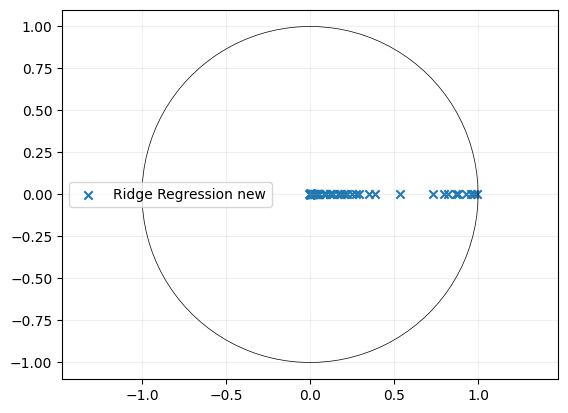

In [24]:
plt.scatter(results['eigenvalues'].real, results['eigenvalues'].imag, marker='x', label="Ridge Regression new")
#plt.scatter(e1.real, e1.imag, label="end2end")
plt.grid(alpha=0.2)
plt.legend()
# Draw unit circle
t = np.linspace(0, 2 * np.pi, 100)
r = 1
x = r * np.cos(t)
y = r * np.sin(t)
plt.plot(x, y, color='k', lw=0.5)
plt.axis('equal')

In [25]:
r_fun = results['r_fun']

In [40]:
from mlcolvar.utils.fes import compute_fes

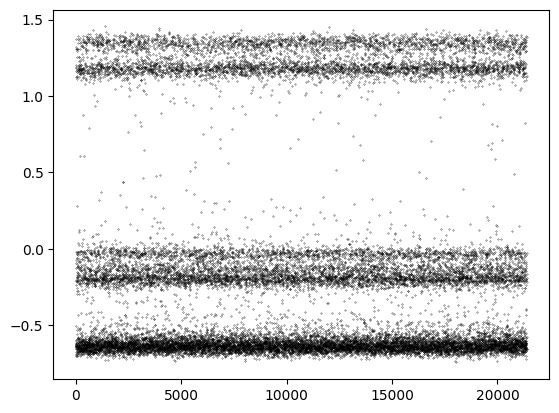

In [27]:
plt.plot(r_fun[:, 1].real, '.', color='k', markersize = 0.5)
#plt.axhline(1.55, color='r')

Text(0, 0.5, 'Tica-2')

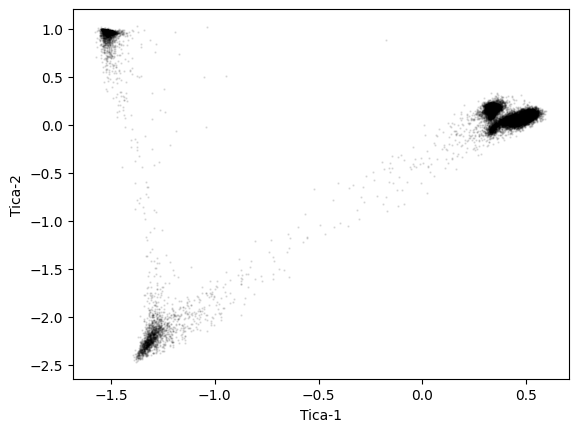

In [40]:
plt.scatter(r_fun[:, 0].real, r_fun[:, 3].real, color='k', s = 0.5, alpha=0.1)
plt.xlabel('Tica-1')
plt.ylabel('Tica-2')
#plt.axvline(1.55, color='r')

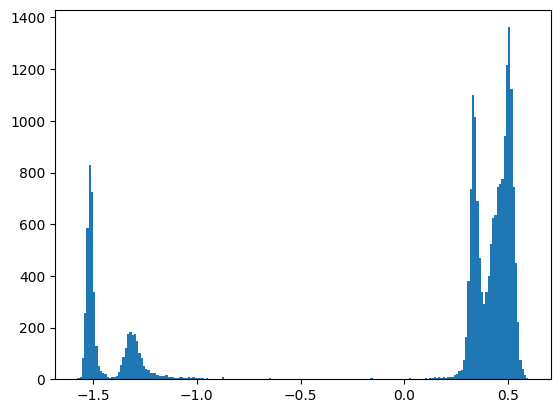

In [30]:
plt.hist(r_fun[:, 0].real, bins=200);

In [41]:
for idx, t in enumerate(implied_timescale(results['eigenvalues'])):
    if idx < 10:
        print(f"{idx:<3} | {t:.2f}ns")


0   | 40.17ns
1   | 7.28ns
2   | 4.52ns
3   | 2.60ns
4   | 1.56ns
5   | 1.40ns
6   | 1.02ns
7   | 0.89ns
8   | 0.65ns
9   | 0.32ns
